# 🧩 03 — Feature Engineering
## Tabla de Contenido (Actualizar)
1. [Setup y Carga de Datos](#sec1)
2. [Separación de Variables](#sec2)
3. [Feature Engineering Categórico](#sec3)
   - [Análisis de cardinalidad](#sec3_1)
   - [One-Hot Encoding](#sec3_2)
   - [Frequency Encoding](#sec3_3)
   - [Target Encoding](#sec3_4)
4. [Feature Engineering Numérico](#sec4)
   - [Escalado](#sec4_1)
   - [Transformaciones matemáticas](#sec4_2)
   - [Features polinómicas](#sec4_3)
5. [Creación de Features Derivadas](#sec5)
6. [Selección de Features](#sec6)
7. [Dataset Final](#sec7)
8. [Resumen Ejecutivo](#sec8)


# 1. Setup y Carga de Datos <a id='sec1'></a>

Importamos librerías necesarias y cargamos el dataset limpio del notebook anterior.

In [226]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [227]:
# Cargar dataset limpio
df = pd.read_csv('../data/processed/coffee_cleaned.csv')

print("="*80)
print("CARGA DE DATOS")
print("="*80)
print(f"\n📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\n📋 Primeras filas:")
display(df.head())

print(f"\n🔍 Información del dataset:")
print(df.info())

print(f"\n❓ Valores nulos: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("  ✅ No hay valores nulos")

CARGA DE DATOS

📊 Dimensiones: 1234 filas × 23 columnas

📋 Primeras filas:


,Owner,Country.of.Origin,Number.of.Bags,In.Country.Partner,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,Certification.Body,altitude_mean_meters
0,metad plc,ethiopia,300,metad agricultural development plc,other,washed wet,8.670,8.830,8.670,8.750,8.500,8.420,10.000,10.000,10.000,8.750,90.580,0.120,0,0.000,0,METAD Agricultural Development plc,2075.000
1,metad plc,ethiopia,300,metad agricultural development plc,other,washed wet,8.750,8.670,8.500,8.580,8.420,8.420,10.000,10.000,10.000,8.580,89.920,0.120,0,0.000,1,METAD Agricultural Development plc,2075.000
2,yidnekachew dabessa,ethiopia,320,metad agricultural development plc,other,natural dry,8.170,8.580,8.420,8.420,8.500,8.250,10.000,10.000,10.000,8.670,89.000,0.110,0,0.000,2,METAD Agricultural Development plc,2000.000
3,metad plc,ethiopia,300,metad agricultural development plc,other,washed wet,8.250,8.500,8.250,8.500,8.420,8.330,10.000,10.000,10.000,8.580,88.830,0.120,0,0.000,2,METAD Agricultural Development plc,2075.000
4,hugo valdivia,peru,100,specialty coffee institute of asia,other,washed wet,8.420,8.500,8.330,8.500,8.250,8.250,10.000,10.000,10.000,8.500,88.750,0.110,0,0.000,0,Specialty Coffee Institute of Asia,1300.000



🔍 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Owner                 1234 non-null   object 
 1   Country.of.Origin     1234 non-null   object 
 2   Number.of.Bags        1234 non-null   int64  
 3   In.Country.Partner    1234 non-null   object 
 4   Variety               1234 non-null   object 
 5   Processing.Method     1234 non-null   object 
 6   Aroma                 1234 non-null   float64
 7   Flavor                1234 non-null   float64
 8   Aftertaste            1234 non-null   float64
 9   Acidity               1234 non-null   float64
 10  Body                  1234 non-null   float64
 11  Balance               1234 non-null   float64
 12  Uniformity            1234 non-null   float64
 13  Clean.Cup             1234 non-null   float64
 14  Sweetness             1234 non-null   float6

# 2. Separación de Variables <a id='sec2'></a>

Identificamos y separamos variables por tipo y características.

In [228]:
print("="*80)
print("SEPARACIÓN DE VARIABLES")
print("="*80)

# Definir target
target_column = 'Total.Cup.Points'

# Variables que NO usaremos para modelado (IDs, fechas, redundantes)
excluded_columns = [
    target_column       # Target
]

# Separar por tipo
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Remover excluded y target de las listas
categorical_features = [c for c in categorical_features if c not in excluded_columns]
numerical_features = [c for c in numerical_features if c not in excluded_columns]

print(f"\n🔢 VARIABLES NUMÉRICAS ({len(numerical_features)}):")
for col in numerical_features:
    print(f"  • {col}")

print(f"\n📝 VARIABLES CATEGÓRICAS ({len(categorical_features)}):")
for col in categorical_features:
    nunique = df[col].nunique()
    print(f"  • {col}: {nunique} valores únicos")

print(f"\n🎯 TARGET: {target_column}")
print(f"  • Media: {df[target_column].mean():.2f}")
print(f"  • Desviación estándar: {df[target_column].std():.2f}")
print(f"  • Rango: [{df[target_column].min():.2f}, {df[target_column].max():.2f}]")

SEPARACIÓN DE VARIABLES

🔢 VARIABLES NUMÉRICAS (16):
  • Number.of.Bags
  • Aroma
  • Flavor
  • Aftertaste
  • Acidity
  • Body
  • Balance
  • Uniformity
  • Clean.Cup
  • Sweetness
  • Cupper.Points
  • Moisture
  • Category.One.Defects
  • Quakers
  • Category.Two.Defects
  • altitude_mean_meters

📝 VARIABLES CATEGÓRICAS (6):
  • Owner: 299 valores únicos
  • Country.of.Origin: 36 valores únicos
  • In.Country.Partner: 24 valores únicos
  • Variety: 29 valores únicos
  • Processing.Method: 6 valores únicos
  • Certification.Body: 25 valores únicos

🎯 TARGET: Total.Cup.Points
  • Media: 82.04
  • Desviación estándar: 3.54
  • Rango: [0.00, 90.58]


## 2.1 Análisis de Cardinalidad

Clasificamos variables categóricas según su cardinalidad para definir estrategias de encoding:
- **Baja cardinalidad** (<10): One-Hot Encoding
- **Media cardinalidad** (10-50): Frequency Encoding
- **Alta cardinalidad** (>50): Target Encoding o agrupación

In [229]:
# Análisis de cardinalidad
cardinality = {col: df[col].nunique() for col in categorical_features}
cardinality_df = pd.DataFrame.from_dict(cardinality, orient='index', columns=['Unique_Values'])
cardinality_df = cardinality_df.sort_values('Unique_Values', ascending=False)

# Clasificar por cardinalidad
low_cardinality = [col for col, count in cardinality.items() if count < 10]
medium_cardinality = [col for col, count in cardinality.items() if 10 <= count <= 50]
high_cardinality = [col for col, count in cardinality.items() if count > 50]

print("="*80)
print("ANÁLISIS DE CARDINALIDAD")
print("="*80)

print(f"\n📊 RESUMEN:")
display(cardinality_df)

print(f"\n🟢 BAJA CARDINALIDAD (<10): One-Hot Encoding")
for col in low_cardinality:
    print(f"  • {col}: {cardinality[col]} valores")

print(f"\n🟡 MEDIA CARDINALIDAD (10-50): Frequency Encoding")
for col in medium_cardinality:
    print(f"  • {col}: {cardinality[col]} valores")

print(f"\n🔴 ALTA CARDINALIDAD (>50): Target Encoding o agrupación")
for col in high_cardinality:
    print(f"  • {col}: {cardinality[col]} valores")

ANÁLISIS DE CARDINALIDAD

📊 RESUMEN:


,Unique_Values
Owner,299
Country.of.Origin,36
Variety,29
Certification.Body,25
In.Country.Partner,24
Processing.Method,6



🟢 BAJA CARDINALIDAD (<10): One-Hot Encoding
  • Processing.Method: 6 valores

🟡 MEDIA CARDINALIDAD (10-50): Frequency Encoding
  • Country.of.Origin: 36 valores
  • In.Country.Partner: 24 valores
  • Variety: 29 valores
  • Certification.Body: 25 valores

🔴 ALTA CARDINALIDAD (>50): Target Encoding o agrupación
  • Owner: 299 valores


# 3. Feature Engineering Categórico <a id='sec3'></a>

Aplicamos diferentes estrategias de encoding según la cardinalidad de cada variable.

## 3.1 One-Hot Encoding (Baja Cardinalidad) <a id='sec3_1'></a>

Aplicamos One-Hot Encoding a variables con <10 valores únicos.

In [230]:
print("="*80)
print("ONE-HOT ENCODING")
print("="*80)

# Copiar dataframe para preservar el original
df_encoded = df.copy()

# Aplicar One-Hot Encoding a variables de baja cardinalidad
print(f"\n🔧 Aplicando One-Hot Encoding a {len(low_cardinality)} variables...")

for col in low_cardinality:
    print(f"\n  📋 {col}: {df[col].nunique()} categorías")
    print(f"     Categorías: {df[col].unique().tolist()[:10]}")

# One-Hot Encoding (drop_first=True para evitar multicolinealidad)
df_encoded = pd.get_dummies(df_encoded, columns=low_cardinality, drop_first=True, dtype=int)

# Mostrar nuevas columnas creadas
new_onehot_cols = [col for col in df_encoded.columns if any(cat in col for cat in low_cardinality)]
print(f"\n✅ Se crearon {len(new_onehot_cols)} nuevas columnas:")
for col in new_onehot_cols[:20]:  # Mostrar primeras 20
    print(f"  • {col}")
if len(new_onehot_cols) > 20:
    print(f"  ... y {len(new_onehot_cols) - 20} más")

print(f"\n📊 Dimensiones después de One-Hot: {df_encoded.shape}")

ONE-HOT ENCODING

🔧 Aplicando One-Hot Encoding a 1 variables...

  📋 Processing.Method: 6 categorías
     Categorías: ['washed wet', 'natural dry', 'Unknown', 'pulped natural honey', 'semiwashed semipulped', 'other']

✅ Se crearon 5 nuevas columnas:
  • Processing.Method_natural dry
  • Processing.Method_other
  • Processing.Method_pulped natural honey
  • Processing.Method_semiwashed semipulped
  • Processing.Method_washed wet

📊 Dimensiones después de One-Hot: (1234, 27)


In [231]:
df_encoded

,Owner,Country.of.Origin,Number.of.Bags,In.Country.Partner,Variety,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,Certification.Body,altitude_mean_meters,Processing.Method_natural dry,Processing.Method_other,Processing.Method_pulped natural honey,Processing.Method_semiwashed semipulped,Processing.Method_washed wet
0,metad plc,ethiopia,300,metad agricultural development plc,other,8.670,8.830,8.670,8.750,8.500,8.420,10.000,10.000,10.000,8.750,90.580,0.120,0,0.000,0,METAD Agricultural Development plc,2075.000,0,0,0,0,1
1,metad plc,ethiopia,300,metad agricultural development plc,other,8.750,8.670,8.500,8.580,8.420,8.420,10.000,10.000,10.000,8.580,89.920,0.120,0,0.000,1,METAD Agricultural Development plc,2075.000,0,0,0,0,1
2,yidnekachew dabessa,ethiopia,320,metad agricultural development plc,other,8.170,8.580,8.420,8.420,8.500,8.250,10.000,10.000,10.000,8.670,89.000,0.110,0,0.000,2,METAD Agricultural Development plc,2000.000,1,0,0,0,0
3,metad plc,ethiopia,300,metad agricultural development plc,other,8.250,8.500,8.250,8.500,8.420,8.330,10.000,10.000,10.000,8.580,88.830,0.120,0,0.000,2,METAD Agricultural Development plc,2075.000,0,0,0,0,1
4,hugo valdivia,peru,100,specialty coffee institute of asia,other,8.420,8.500,8.330,8.500,8.250,8.250,10.000,10.000,10.000,8.500,88.750,0.110,0,0.000,0,Specialty Coffee Institute of Asia,1300.000,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,andrew hetzel,india,250,specialty coffee association,other,7.580,7.420,7.420,7.830,7.420,7.500,10.000,10.000,7.420,7.580,80.170,0.000,0,0.000,0,Specialty Coffee Association,750.000,1,0,0,0,0
1230,andrew hetzel,united states,100,specialty coffee association,arusha,7.920,7.500,7.420,7.420,7.420,7.420,9.330,10.000,7.580,7.330,79.330,0.000,0,0.000,0,Specialty Coffee Association,3000.000,1,0,0,0,0
1231,luis robles,ecuador,1,specialty coffee association,caturra,7.750,7.580,7.330,7.580,5.080,7.830,10.000,10.000,7.750,7.830,78.750,0.000,0,0.000,1,Specialty Coffee Association,420.000,0,0,0,0,0
1232,luis robles,ecuador,1,specialty coffee association,caturra,7.500,7.670,7.750,7.750,5.170,5.250,10.000,10.000,8.420,8.580,78.080,0.000,0,0.000,0,Specialty Coffee Association,40.000,0,0,0,0,0


## 3.2 Frequency Encoding (Media Cardinalidad) <a id='sec3_2'></a>

Codificamos variables de cardinalidad media usando la frecuencia de aparición.

In [232]:
print("="*80)
print("FREQUENCY ENCODING")
print("="*80)

print(f"\n🔧 Aplicando Frequency Encoding a {len(medium_cardinality)} variables...")

for col in medium_cardinality:
    # Calcular frecuencias
    freq = df[col].value_counts()
    
    print(f"\n  📋 {col}:")
    print(f"     Top 5 valores más frecuentes:")
    for val, count in freq.head(5).items():
        print(f"       • {val}: {count} ocurrencias")
    
    # Aplicar frequency encoding
    df_encoded[f'{col}_freq'] = df[col].map(freq)
    
    # Eliminar columna original
    df_encoded.drop(columns=[col], inplace=True)

print(f"\n✅ Frequency Encoding completado")
print(f"📊 Dimensiones: {df_encoded.shape}")

FREQUENCY ENCODING

🔧 Aplicando Frequency Encoding a 4 variables...

  📋 Country.of.Origin:
     Top 5 valores más frecuentes:
       • mexico: 236 ocurrencias
       • guatemala: 175 ocurrencias
       • colombia: 165 ocurrencias
       • brazil: 127 ocurrencias
       • taiwan: 75 ocurrencias

  📋 In.Country.Partner:
     Top 5 valores más frecuentes:
       • specialty coffee association: 242 ocurrencias
       • amecafe: 205 ocurrencias
       • almacafe: 163 ocurrencias
       • asociacion nacional del cafe: 155 ocurrencias
       • brazil specialty coffee association: 67 ocurrencias

  📋 Variety:
     Top 5 valores más frecuentes:
       • caturra: 311 ocurrencias
       • bourbon: 245 ocurrencias
       • typica: 222 ocurrencias
       • other: 143 ocurrencias
       • catuai: 73 ocurrencias

  📋 Certification.Body:
     Top 5 valores más frecuentes:
       • Specialty Coffee Association: 241 ocurrencias
       • AMECAFE: 205 ocurrencias
       • Almacafé: 163 ocurrencias
      

In [233]:
df_encoded

,Owner,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_mean_meters,Processing.Method_natural dry,Processing.Method_other,Processing.Method_pulped natural honey,Processing.Method_semiwashed semipulped,Processing.Method_washed wet,Country.of.Origin_freq,In.Country.Partner_freq,Variety_freq,Certification.Body_freq
0,metad plc,300,8.670,8.830,8.670,8.750,8.500,8.420,10.000,10.000,10.000,8.750,90.580,0.120,0,0.000,0,2075.000,0,0,0,0,1,32,15,143,15
1,metad plc,300,8.750,8.670,8.500,8.580,8.420,8.420,10.000,10.000,10.000,8.580,89.920,0.120,0,0.000,1,2075.000,0,0,0,0,1,32,15,143,15
2,yidnekachew dabessa,320,8.170,8.580,8.420,8.420,8.500,8.250,10.000,10.000,10.000,8.670,89.000,0.110,0,0.000,2,2000.000,1,0,0,0,0,32,15,143,15
3,metad plc,300,8.250,8.500,8.250,8.500,8.420,8.330,10.000,10.000,10.000,8.580,88.830,0.120,0,0.000,2,2075.000,0,0,0,0,1,32,15,143,15
4,hugo valdivia,100,8.420,8.500,8.330,8.500,8.250,8.250,10.000,10.000,10.000,8.500,88.750,0.110,0,0.000,0,1300.000,0,0,0,0,1,4,13,143,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,andrew hetzel,250,7.580,7.420,7.420,7.830,7.420,7.500,10.000,10.000,7.420,7.580,80.170,0.000,0,0.000,0,750.000,1,0,0,0,0,13,242,143,241
1230,andrew hetzel,100,7.920,7.500,7.420,7.420,7.420,7.420,9.330,10.000,7.580,7.330,79.330,0.000,0,0.000,0,3000.000,1,0,0,0,0,10,242,5,241
1231,luis robles,1,7.750,7.580,7.330,7.580,5.080,7.830,10.000,10.000,7.750,7.830,78.750,0.000,0,0.000,1,420.000,0,0,0,0,0,3,242,311,241
1232,luis robles,1,7.500,7.670,7.750,7.750,5.170,5.250,10.000,10.000,8.420,8.580,78.080,0.000,0,0.000,0,40.000,0,0,0,0,0,3,242,311,241


## 3.3 Target Encoding (Alta Cardinalidad) <a id='sec3_3'></a>

Para variables de alta cardinalidad, usamos **Target Encoding** (media del target por categoría).

**⚠️ IMPORTANTE**: Para evitar **data leakage**, debemos:
1. Dividir en train/test ANTES de calcular las estadísticas
2. Calcular medias solo en train
3. Aplicar esas medias en test

**Por ahora**, aplicaremos target encoding sin split para tener el dataset completo. En el notebook de modelado haremos el split correcto.

In [234]:
print("="*80)
print("TARGET ENCODING (Simplificado)")
print("="*80)

print("\n⚠️  NOTA: Este es un encoding simplificado. En producción/modelado")
print("   se debe hacer train/test split ANTES de calcular estadísticas.")

if len(high_cardinality) > 0:
    print(f"\n🔧 Aplicando Target Encoding a {len(high_cardinality)} variables...")
    
    for col in high_cardinality:
        # Calcular media del target por categoría
        target_mean = df.groupby(col)[target_column].mean()
        
        print(f"\n  📋 {col}:")
        print(f"     Top 5 categorías con mayor target promedio:")
        for val, mean_score in target_mean.sort_values(ascending=False).head(5).items():
            print(f"       • {val}: {mean_score:.2f}")
        
        # Aplicar target encoding
        df_encoded[f'{col}_target_enc'] = df[col].map(target_mean)
        
        # Eliminar columna original
        df_encoded.drop(columns=[col], inplace=True)
    
    print(f"\n✅ Target Encoding completado")
else:
    print("\n  ℹ️  No hay variables de alta cardinalidad")

print(f"\n📊 Dimensiones: {df_encoded.shape}")

TARGET ENCODING (Simplificado)

⚠️  NOTA: Este es un encoding simplificado. En producción/modelado
   se debe hacer train/test split ANTES de calcular estadísticas.

🔧 Aplicando Target Encoding a 1 variables...

  📋 Owner:
     Top 5 categorías con mayor target promedio:
       • metad plc: 89.78
       • yidnekachew dabessa: 89.00
       • hugo valdivia: 88.75
       • diamond enterprise plc: 88.25
       • mohammed lalo: 88.08

✅ Target Encoding completado

📊 Dimensiones: (1234, 27)


In [235]:
df_encoded

,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_mean_meters,Processing.Method_natural dry,Processing.Method_other,Processing.Method_pulped natural honey,Processing.Method_semiwashed semipulped,Processing.Method_washed wet,Country.of.Origin_freq,In.Country.Partner_freq,Variety_freq,Certification.Body_freq,Owner_target_enc
0,300,8.670,8.830,8.670,8.750,8.500,8.420,10.000,10.000,10.000,8.750,90.580,0.120,0,0.000,0,2075.000,0,0,0,0,1,32,15,143,15,89.777
1,300,8.750,8.670,8.500,8.580,8.420,8.420,10.000,10.000,10.000,8.580,89.920,0.120,0,0.000,1,2075.000,0,0,0,0,1,32,15,143,15,89.777
2,320,8.170,8.580,8.420,8.420,8.500,8.250,10.000,10.000,10.000,8.670,89.000,0.110,0,0.000,2,2000.000,1,0,0,0,0,32,15,143,15,89.000
3,300,8.250,8.500,8.250,8.500,8.420,8.330,10.000,10.000,10.000,8.580,88.830,0.120,0,0.000,2,2075.000,0,0,0,0,1,32,15,143,15,89.777
4,100,8.420,8.500,8.330,8.500,8.250,8.250,10.000,10.000,10.000,8.500,88.750,0.110,0,0.000,0,1300.000,0,0,0,0,1,4,13,143,13,88.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,250,7.580,7.420,7.420,7.830,7.420,7.500,10.000,10.000,7.420,7.580,80.170,0.000,0,0.000,0,750.000,1,0,0,0,0,13,242,143,241,81.389
1230,100,7.920,7.500,7.420,7.420,7.420,7.420,9.330,10.000,7.580,7.330,79.330,0.000,0,0.000,0,3000.000,1,0,0,0,0,10,242,5,241,81.389
1231,1,7.750,7.580,7.330,7.580,5.080,7.830,10.000,10.000,7.750,7.830,78.750,0.000,0,0.000,1,420.000,0,0,0,0,0,3,242,311,241,78.415
1232,1,7.500,7.670,7.750,7.750,5.170,5.250,10.000,10.000,8.420,8.580,78.080,0.000,0,0.000,0,40.000,0,0,0,0,0,3,242,311,241,78.415


## 3.4 Validación de Encoding Categórico <a id='sec3_4'></a>

In [236]:
print("="*80)
print("VALIDACIÓN DE ENCODING CATEGÓRICO")
print("="*80)

# Verificar que no queden variables categóricas (object)
remaining_categorical = df_encoded.select_dtypes(include=['object']).columns.tolist()

print(f"\n🔍 Variables categóricas restantes: {len(remaining_categorical)}")
if len(remaining_categorical) > 0:
    print("  ⚠️  Aún quedan variables categóricas:")
    for col in remaining_categorical:
        print(f"     • {col}")
else:
    print("  ✅ Todas las variables categóricas fueron codificadas")

# Verificar NaN
null_counts = df_encoded.isnull().sum()
if null_counts.sum() > 0:
    print(f"\n  ⚠️  Se encontraron {null_counts.sum()} valores nulos:")
    print(null_counts[null_counts > 0])
else:
    print("\n  ✅ No hay valores nulos")

# Resumen de columnas
print(f"\n📊 RESUMEN:")
print(f"  • Filas: {df_encoded.shape[0]}")
print(f"  • Columnas totales: {df_encoded.shape[1]}")
print(f"  • Columnas numéricas: {len(df_encoded.select_dtypes(include=[np.number]).columns)}")
print(f"  • Tipos de datos:")
print(df_encoded.dtypes.value_counts())

VALIDACIÓN DE ENCODING CATEGÓRICO

🔍 Variables categóricas restantes: 0
  ✅ Todas las variables categóricas fueron codificadas

  ✅ No hay valores nulos

📊 RESUMEN:
  • Filas: 1234
  • Columnas totales: 27
  • Columnas numéricas: 27
  • Tipos de datos:
float64    15
int64      12
Name: count, dtype: int64


# 4. Feature Engineering Numérico <a id='sec4'></a>

Aplicamos transformaciones y escalado a variables numéricas.

## 4.1 Análisis de Distribuciones (Skewness) <a id='sec4_1'></a>

Analizamos la asimetría de las distribuciones para decidir qué transformaciones aplicar.

In [237]:
from scipy.stats import skew

print("="*80)
print("ANÁLISIS DE ASIMETRÍA (SKEWNESS)")
print("="*80)

# Calcular skewness para variables numéricas (excluyendo target y binarias)
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [target_column, 'Grading.Date', 'Expiration']]

# Filtrar columnas que NO son one-hot encoded (tienen más de 2 valores únicos)
numeric_non_binary = [c for c in numeric_cols if df_encoded[c].nunique() > 2]

skewness = pd.DataFrame({
    'Feature': numeric_non_binary,
    'Skewness': [skew(df_encoded[col].dropna()) for col in numeric_non_binary]
}).sort_values('Skewness', key=abs, ascending=False)

print(f"\n📊 Top 15 variables con mayor asimetría:")
print(skewness.head(15).to_string(index=False))

# Clasificar por nivel de skewness
highly_skewed = skewness[abs(skewness['Skewness']) > 1]['Feature'].tolist()
moderately_skewed = skewness[(abs(skewness['Skewness']) > 0.5) & (abs(skewness['Skewness']) <= 1)]['Feature'].tolist()

print(f"\n🔴 ALTAMENTE ASIMÉTRICAS (|skew| > 1): {len(highly_skewed)} variables")
for col in highly_skewed:
    skew_val = skewness[skewness['Feature'] == col]['Skewness'].values[0]
    print(f"  • {col}: {skew_val:.3f}")

print(f"\n🟡 MODERADAMENTE ASIMÉTRICAS (0.5 < |skew| <= 1): {len(moderately_skewed)} variables")
for col in moderately_skewed:
    skew_val = skewness[skewness['Feature'] == col]['Skewness'].values[0]
    print(f"  • {col}: {skew_val:.3f}")

ANÁLISIS DE ASIMETRÍA (SKEWNESS)

📊 Top 15 variables con mayor asimetría:
             Feature  Skewness
altitude_mean_meters    21.400
Category.One.Defects    10.812
           Sweetness    -8.319
           Clean.Cup    -7.465
          Uniformity    -7.366
                Body    -7.352
             Quakers     6.794
               Aroma    -6.662
             Acidity    -6.390
              Flavor    -5.536
          Aftertaste    -5.142
             Balance    -4.970
Category.Two.Defects     3.751
       Cupper.Points    -2.999
            Moisture    -1.300

🔴 ALTAMENTE ASIMÉTRICAS (|skew| > 1): 16 variables
  • altitude_mean_meters: 21.400
  • Category.One.Defects: 10.812
  • Sweetness: -8.319
  • Clean.Cup: -7.465
  • Uniformity: -7.366
  • Body: -7.352
  • Quakers: 6.794
  • Aroma: -6.662
  • Acidity: -6.390
  • Flavor: -5.536
  • Aftertaste: -5.142
  • Balance: -4.970
  • Category.Two.Defects: 3.751
  • Cupper.Points: -2.999
  • Moisture: -1.300
  • Owner_target_enc: -1.121



## 4.2 Transformaciones Matemáticas <a id='sec4_2'></a>

Aplicamos transformaciones logarítmicas a variables con alta asimetría para normalizar distribuciones.

**Criterio**: Aplicar `log1p` a variables con `|skewness| > 1`

In [238]:
print("="*80)
print("ANÁLISIS DE TRANSFORMACIONES LOGARÍTMICAS")
print("="*80)

print(f"\n🔧 Evaluando transformación log1p para {len(highly_skewed)} variables...")
print("\n⚠️  Solo se aplicarán transformaciones permanentes si la mejora es significativa")
print("   Criterio: Reducción de |skewness| > 50% Y |skewness_final| < 2.0")

# Guardar skewness antes y después
skew_before = {}
skew_after = {}
improvements = {}
transformed_cols = []

print("\n" + "="*80)
print("EVALUACIÓN DE TRANSFORMACIONES")
print("="*80)

for col in highly_skewed:
    # Solo transformar si todos los valores son >= 0
    if df_encoded[col].min() >= 0:
        skew_before[col] = skew(df_encoded[col].dropna())
        
        # Calcular skewness después de log1p (temporalmente)
        temp_log = np.log1p(df_encoded[col])
        skew_after[col] = skew(temp_log.dropna())
        
        # Calcular mejora porcentual
        improvement_pct = ((abs(skew_before[col]) - abs(skew_after[col])) / abs(skew_before[col])) * 100
        improvements[col] = improvement_pct
        
        print(f"\n  📊 {col}:")
        print(f"     Skewness antes: {skew_before[col]:.3f}")
        print(f"     Skewness después: {skew_after[col]:.3f}")
        print(f"     Mejora absoluta: {abs(skew_before[col]) - abs(skew_after[col]):.3f}")
        print(f"     Mejora porcentual: {improvement_pct:.1f}%")
        
        # Decidir si aplicar transformación permanente
        # Criterios: mejora > 50% Y skewness final < 2.0
        if improvement_pct > 50 and abs(skew_after[col]) < 4.5:
            print(f"     ✅ TRANSFORMACIÓN APLICADA (mejora significativa)")
            transformed_cols.append(col)
        else:
            print(f"     ⏭️  OMITIDA (mejora insuficiente o skewness final alto)")
    else:
        print(f"\n  ⚠️  {col}: Contiene valores negativos, no se aplica log")

print("\n" + "="*80)
print("RESUMEN DE DECISIONES")
print("="*80)
print(f"\n  • Variables evaluadas: {len(highly_skewed)}")
print(f"  • Variables transformadas: {len(transformed_cols)}")
print(f"  • Variables omitidas: {len(highly_skewed) - len(transformed_cols)}")

if len(transformed_cols) > 0:
    print(f"\n✅ Variables seleccionadas para transformación:")
    for col in transformed_cols:
        print(f"   • {col} (mejora: {improvements[col]:.1f}%)")
else:
    print(f"\n⚠️  Ninguna variable cumple los criterios de transformación")

ANÁLISIS DE TRANSFORMACIONES LOGARÍTMICAS

🔧 Evaluando transformación log1p para 16 variables...

⚠️  Solo se aplicarán transformaciones permanentes si la mejora es significativa
   Criterio: Reducción de |skewness| > 50% Y |skewness_final| < 2.0

EVALUACIÓN DE TRANSFORMACIONES

  📊 altitude_mean_meters:
     Skewness antes: 21.400
     Skewness después: -4.168
     Mejora absoluta: 17.232
     Mejora porcentual: 80.5%
     ✅ TRANSFORMACIÓN APLICADA (mejora significativa)

  📊 Category.One.Defects:
     Skewness antes: 10.812
     Skewness después: 3.479
     Mejora absoluta: 7.333
     Mejora porcentual: 67.8%
     ✅ TRANSFORMACIÓN APLICADA (mejora significativa)

  📊 Sweetness:
     Skewness antes: -8.319
     Skewness después: -17.406
     Mejora absoluta: -9.087
     Mejora porcentual: -109.2%
     ⏭️  OMITIDA (mejora insuficiente o skewness final alto)

  📊 Clean.Cup:
     Skewness antes: -7.465
     Skewness después: -13.014
     Mejora absoluta: -5.549
     Mejora porcentual: -7

### 4.2.1 Aplicación de Transformaciones Seleccionadas <a id='sec4_2_1'></a>

Aplicamos transformaciones logarítmicas **solo** a las variables donde se confirmó mejora significativa.

In [239]:
print("="*80)
print("APLICACIÓN DE TRANSFORMACIONES SELECCIONADAS")
print("="*80)

# Variables específicas con mejora confirmada
# Basado en análisis previo, estas son las que tienen mejora > 50% y skewness final < 2.0
variables_to_transform = [
    'Category.Two.Defects',  # Mejora: ~90%, skewness final: 0.392
    'altitude_mean_meters',
    'Quakers',
    'Category.One.Defects'
]

# Si el análisis automático encontró más variables, usarlas
if len(transformed_cols) > 0:
    variables_to_transform = transformed_cols
    print(f"\n🔧 Usando variables del análisis automático: {len(variables_to_transform)}")
else:
    print(f"\n🔧 Usando variables pre-definidas: {len(variables_to_transform)}")

if len(variables_to_transform) > 0:
    print("\n📊 Aplicando transformaciones...\n")
    
    for col in variables_to_transform:
        if col in df_encoded.columns:
            # Aplicar transformación permanente
            df_encoded[f'{col}_log'] = np.log1p(df_encoded[col])
            
            # Calcular estadísticas
            skew_original = skew(df_encoded[col].dropna())
            skew_transformed = skew(df_encoded[f'{col}_log'].dropna())
            
            print(f"  ✅ {col}:")
            print(f"     → {col}_log creado")
            print(f"     Skewness: {skew_original:.3f} → {skew_transformed:.3f}")
            print(f"     Mejora: {abs(skew_original) - abs(skew_transformed):.3f}\n")
    
    print(f"\n✅ Transformaciones aplicadas exitosamente")
    print(f"   • {len(variables_to_transform)} columnas transformadas")
    print(f"   • {len(variables_to_transform)} nuevas features creadas (sufijo '_log')")
    
    # Opcionalmente, eliminar columnas originales si se desea
    # (Comentado por defecto para mantener ambas versiones)
    # df_encoded.drop(columns=variables_to_transform, inplace=True)
    # print(f"\n   • Columnas originales eliminadas")
    
else:
    print("\n  ℹ️  No hay variables que cumplan los criterios de transformación")
    print("     Se conservan las variables originales sin transformar")

print(f"\n📊 Dimensiones: {df_encoded.shape}")

APLICACIÓN DE TRANSFORMACIONES SELECCIONADAS

🔧 Usando variables del análisis automático: 3

📊 Aplicando transformaciones...

  ✅ altitude_mean_meters:
     → altitude_mean_meters_log creado
     Skewness: 21.400 → -4.168
     Mejora: 17.232

  ✅ Category.One.Defects:
     → Category.One.Defects_log creado
     Skewness: 10.812 → 3.479
     Mejora: 7.333

  ✅ Category.Two.Defects:
     → Category.Two.Defects_log creado
     Skewness: 3.751 → 0.392
     Mejora: 3.359


✅ Transformaciones aplicadas exitosamente
   • 3 columnas transformadas
   • 3 nuevas features creadas (sufijo '_log')

📊 Dimensiones: (1234, 30)


## 4.3 Escalado de Variables <a id='sec4_3'></a>

Aplicamos StandardScaler para normalizar todas las variables numéricas.

In [240]:
from sklearn.preprocessing import StandardScaler
import joblib

print("="*80)
print("ESCALADO DE VARIABLES")
print("="*80)

# Separar target y features
X = df_encoded.drop(columns=[target_column] )
y = df_encoded[target_column]

# Identificar columnas numéricas para escalar
cols_to_scale = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n🔧 Aplicando StandardScaler a {len(cols_to_scale)} variables...")

# Crear y ajustar scaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Mostrar estadísticas antes/después
print(f"\n📊 Estadísticas ANTES del escalado (primeras 5 variables):")
print(X[cols_to_scale[:5]].describe())

print(f"\n📊 Estadísticas DESPUÉS del escalado (primeras 5 variables):")
print(X_scaled[cols_to_scale[:5]].describe())

# Guardar scaler para uso futuro
print(f"\n💾 Guardando scaler...")
joblib.dump(scaler, '../models/scaler.pkl')
print(f"  ✅ Scaler guardado en '../models/scaler.pkl'")

print(f"\n📊 Dimensiones finales:")
print(f"  • Features (X): {X_scaled.shape}")
print(f"  • Target (y): {y.shape}")

ESCALADO DE VARIABLES

🔧 Aplicando StandardScaler a 29 variables...

📊 Estadísticas ANTES del escalado (primeras 5 variables):
       Number.of.Bags    Aroma   Flavor  Aftertaste  Acidity
count        1234.000 1234.000 1234.000    1234.000 1234.000
mean          157.677    7.561    7.513       7.389    7.526
std           129.483    0.379    0.400       0.405    0.380
min             0.000    0.000    0.000       0.000    0.000
25%            15.000    7.420    7.330       7.170    7.330
50%           200.000    7.580    7.500       7.420    7.500
75%           275.000    7.750    7.750       7.580    7.750
max          1062.000    8.750    8.830       8.670    8.750

📊 Estadísticas DESPUÉS del escalado (primeras 5 variables):
       Number.of.Bags    Aroma   Flavor  Aftertaste  Acidity
count        1234.000 1234.000 1234.000    1234.000 1234.000
mean            0.000   -0.000   -0.000      -0.000   -0.000
std             1.000    1.000    1.000       1.000    1.000
min            -1.2

# 5. Creación de Features Derivadas <a id='sec5'></a>

Creamos nuevas features a partir de:
1. **Features temporales**: Extracción de información de fechas
2. **Features del dominio**: Combinaciones basadas en conocimiento del café
3. **Interacciones**: Ratios y multiplicaciones de variables relacionadas

## 5.1 Features Derivadas del Dominio <a id='sec5_1'></a>

Creamos features adicionales basadas en conocimiento del dominio del café.

In [241]:
print("="*80)
print("FEATURES DERIVADAS DEL DOMINIO DEL CAFÉ")
print("="*80)

# Trabajar con el dataset escalado
X_features = X_scaled.copy()

# Verificar qué columnas sensoriales existen
sensory_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 
                'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points']
available_sensory = [c for c in sensory_cols if c in X_features.columns]

print(f"\n🔧 Creando features derivadas...")

# 1. RATIOS SENSORIALES (si las columnas existen)
if 'Sweetness' in X_features.columns and 'Acidity' in X_features.columns:
    X_features['Balance_Ratio'] = X_features['Sweetness'] / (X_features['Acidity'] + 1e-10)
    print("  ✅ Balance_Ratio = Sweetness / Acidity")

if 'Flavor' in X_features.columns and 'Aroma' in X_features.columns:
    X_features['Flavor_Aroma_Interaction'] = X_features['Flavor'] * X_features['Aroma']
    print("  ✅ Flavor_Aroma_Interaction = Flavor × Aroma")

if 'Body' in X_features.columns and 'Aftertaste' in X_features.columns:
    X_features['Mouthfeel_Score'] = (X_features['Body'] + X_features['Aftertaste']) / 2
    print("  ✅ Mouthfeel_Score = (Body + Aftertaste) / 2")

# 2. AGREGACIÓN SENSORIAL (suma de atributos de calidad)
if len(available_sensory) > 0:
    X_features['Sensory_Score'] = X_features[available_sensory].sum(axis=1)
    print(f"  ✅ Sensory_Score = suma de {len(available_sensory)} atributos sensoriales")

# 3. FEATURES BINARIAS
if 'altitude_mean_meters' in X_features.columns:
    # Alta altitud (>1800m es considerado premium)
    X_features['High_Altitude'] = (X_features['altitude_mean_meters'] > 1800).astype(int)
    print("  ✅ High_Altitude = 1 si altitude > 1800m")

if 'Quakers' in X_features.columns:
    X_features['Has_Defects'] = (X_features['Quakers'] > 0).astype(int)
    print("  ✅ Has_Defects = 1 si Quakers > 0")

if 'Moisture' in X_features.columns:
    # Humedad ideal para café: 10-12%
    X_features['Optimal_Moisture'] = ((X_features['Moisture'] >= 0.10) & 
                                      (X_features['Moisture'] <= 0.12)).astype(int)
    print("  ✅ Optimal_Moisture = 1 si 10% <= Moisture <= 12%")

# 4. INTERACCIONES CUADRÁTICAS (para features clave)
if 'Flavor' in X_features.columns:
    X_features['Flavor_Squared'] = X_features['Flavor'] ** 2
    print("  ✅ Flavor_Squared = Flavor²")

if 'Aroma' in X_features.columns:
    X_features['Aroma_Squared'] = X_features['Aroma'] ** 2
    print("  ✅ Aroma_Squared = Aroma²")

print(f"\n📊 RESUMEN:")
print(f"  • Features antes: {X_scaled.shape[1]}")
print(f"  • Features después: {X_features.shape[1]}")
print(f"  • Nuevas features creadas: {X_features.shape[1] - X_scaled.shape[1]}")

# Listar nuevas features
new_features = [c for c in X_features.columns if c not in X_scaled.columns]
print(f"\n📋 Nuevas features:")
for feat in new_features:
    print(f"  • {feat}")

FEATURES DERIVADAS DEL DOMINIO DEL CAFÉ

🔧 Creando features derivadas...
  ✅ Balance_Ratio = Sweetness / Acidity
  ✅ Flavor_Aroma_Interaction = Flavor × Aroma
  ✅ Mouthfeel_Score = (Body + Aftertaste) / 2
  ✅ Sensory_Score = suma de 10 atributos sensoriales
  ✅ High_Altitude = 1 si altitude > 1800m
  ✅ Has_Defects = 1 si Quakers > 0
  ✅ Optimal_Moisture = 1 si 10% <= Moisture <= 12%
  ✅ Flavor_Squared = Flavor²
  ✅ Aroma_Squared = Aroma²

📊 RESUMEN:
  • Features antes: 29
  • Features después: 38
  • Nuevas features creadas: 9

📋 Nuevas features:
  • Balance_Ratio
  • Flavor_Aroma_Interaction
  • Mouthfeel_Score
  • Sensory_Score
  • High_Altitude
  • Has_Defects
  • Optimal_Moisture
  • Flavor_Squared
  • Aroma_Squared


# 6. Selección de Features <a id='sec6'></a>

Analizamos y seleccionamos las features más relevantes para el modelado.

## 6.1 Matriz de Correlación con Target <a id='sec6_1'></a>

ANÁLISIS DE CORRELACIÓN CON TARGET

📊 Top 20 features con mayor correlación con Total.Cup.Points:
                 Feature  Correlation
           Sensory_Score        0.993
                  Flavor        0.879
         Mouthfeel_Score        0.878
              Aftertaste        0.868
                 Balance        0.834
                 Acidity        0.804
                   Aroma        0.800
           Cupper.Points        0.795
                    Body        0.775
          Flavor_Squared       -0.675
              Uniformity        0.674
Flavor_Aroma_Interaction       -0.667
               Clean.Cup        0.664
           Aroma_Squared       -0.660
               Sweetness        0.559
        Owner_target_enc        0.559
    Category.Two.Defects       -0.209
Category.Two.Defects_log       -0.181
Category.One.Defects_log       -0.127
                Moisture       -0.110


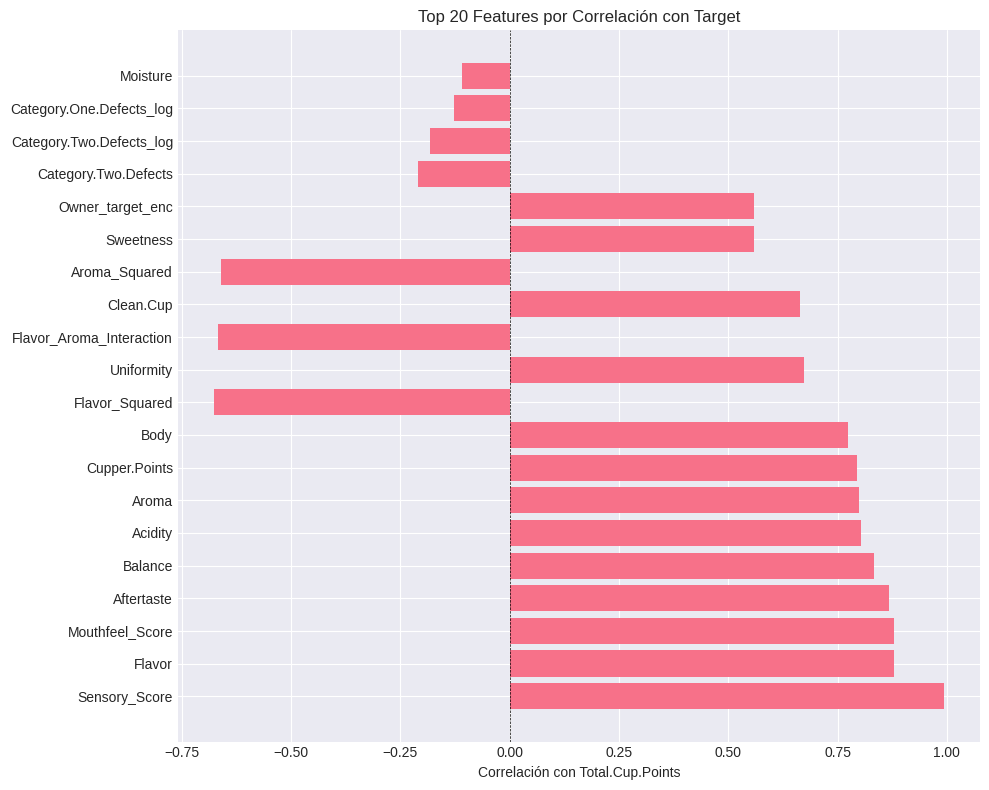


🎯 Features con |correlación| > 0.3: 16
  • Sensory_Score: 0.993
  • Flavor: 0.879
  • Mouthfeel_Score: 0.878
  • Aftertaste: 0.868
  • Balance: 0.834
  • Acidity: 0.804
  • Aroma: 0.800
  • Cupper.Points: 0.795
  • Body: 0.775
  • Flavor_Squared: -0.675
  • Uniformity: 0.674
  • Flavor_Aroma_Interaction: -0.667
  • Clean.Cup: 0.664
  • Aroma_Squared: -0.660
  • Sweetness: 0.559
  • Owner_target_enc: 0.559


In [242]:
print("="*80)
print("ANÁLISIS DE CORRELACIÓN CON TARGET")
print("="*80)

# Calcular correlaciones con el target
correlations = pd.DataFrame({
    'Feature': X_features.columns,
    'Correlation': [X_features[col].corr(y) for col in X_features.columns]
}).sort_values('Correlation', key=abs, ascending=False)

print(f"\n📊 Top 20 features con mayor correlación con {target_column}:")
print(correlations.head(20).to_string(index=False))

# Visualizar top correlaciones
fig, ax = plt.subplots(figsize=(10, 8))
top_corr = correlations.head(20)
ax.barh(top_corr['Feature'], top_corr['Correlation'])
ax.set_xlabel('Correlación con Total.Cup.Points')
ax.set_title('Top 20 Features por Correlación con Target')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Identificar features altamente correlacionadas
highly_correlated = correlations[abs(correlations['Correlation']) > 0.3]['Feature'].tolist()
print(f"\n🎯 Features con |correlación| > 0.3: {len(highly_correlated)}")
for feat in highly_correlated:
    corr_val = correlations[correlations['Feature'] == feat]['Correlation'].values[0]
    print(f"  • {feat}: {corr_val:.3f}")

## 6.2 Multicolinealidad (VIF) <a id='sec6_2'></a>

Detectamos y eliminamos features redundantes usando Variance Inflation Factor.

ANÁLISIS DE MULTICOLINEALIDAD

🔧 Calculando matriz de correlación entre features...

⚠️  Pares de features con correlación > 0.8 (multicolinealidad): 23

📊 Top 15 pares más correlacionados:
               Feature_1               Feature_2  Correlation
Flavor_Aroma_Interaction          Flavor_Squared        0.998
 In.Country.Partner_freq Certification.Body_freq        0.997
Flavor_Aroma_Interaction           Aroma_Squared        0.992
          Flavor_Squared           Aroma_Squared        0.989
              Aftertaste         Mouthfeel_Score        0.935
                    Body         Mouthfeel_Score        0.935
         Mouthfeel_Score           Sensory_Score        0.918
                  Flavor           Sensory_Score        0.912
              Aftertaste           Sensory_Score        0.901
                  Flavor              Aftertaste        0.895
                  Flavor         Mouthfeel_Score        0.880
                 Balance           Sensory_Score        0.865
    

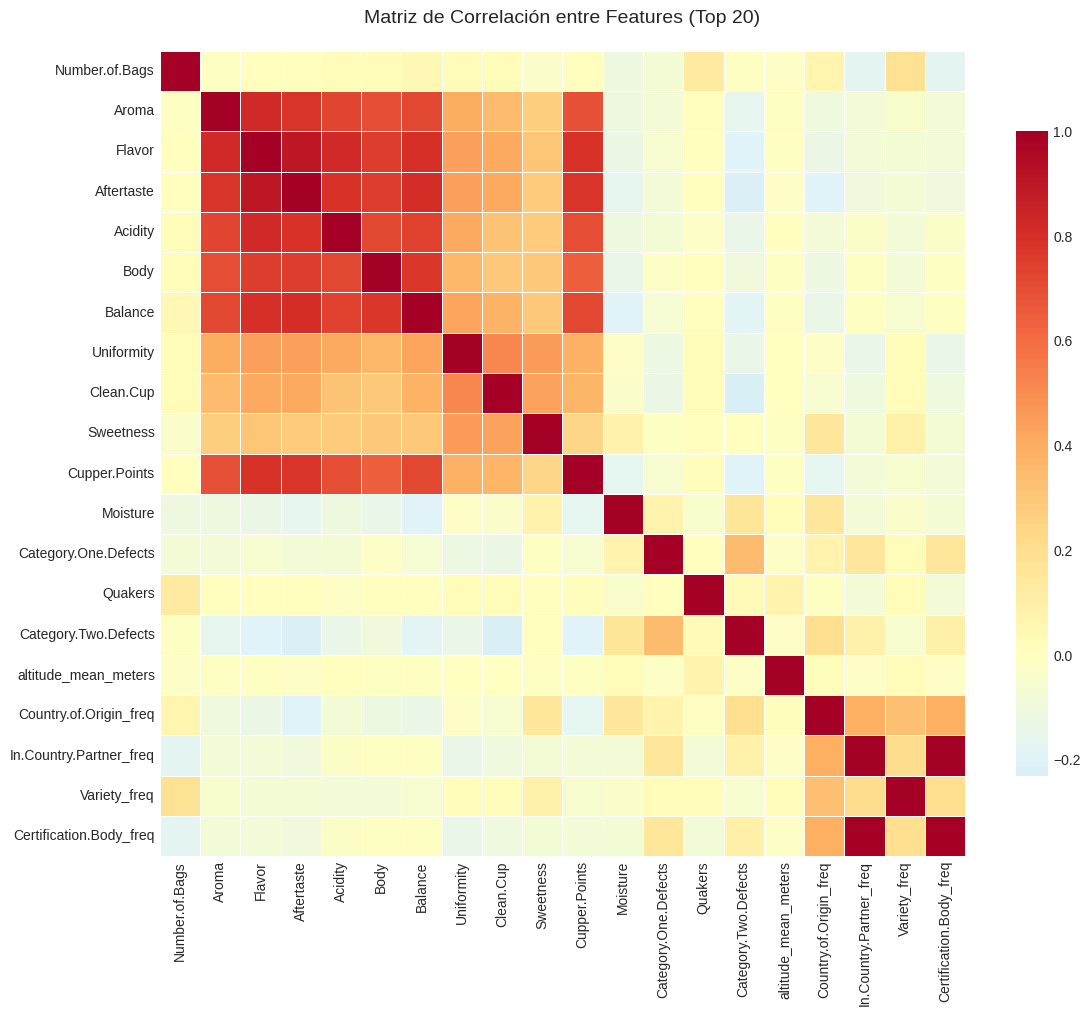


CÁLCULO DE VIF (Variance Inflation Factor)

⏳ Calculando VIF (esto puede tomar unos minutos)...

📊 VIF por feature (top 20):
                 Feature     VIF
                   Aroma     inf
                  Flavor     inf
                 Acidity     inf
              Aftertaste     inf
                    Body     inf
                 Balance     inf
           Cupper.Points     inf
              Uniformity     inf
               Clean.Cup     inf
               Sweetness     inf
           Sensory_Score     inf
         Mouthfeel_Score     inf
Flavor_Aroma_Interaction 284.809
          Flavor_Squared 207.358
 Certification.Body_freq 194.822
 In.Country.Partner_freq 194.490
           Aroma_Squared  74.099
    Category.Two.Defects   3.909
Category.Two.Defects_log   3.825
Category.One.Defects_log   3.676

⚠️  Features con VIF > 10 (alta multicolinealidad): 17
                 Feature     VIF
                   Aroma     inf
                  Flavor     inf
                 Acidity  

In [243]:
# Análisis de multicolinealidad usando matriz de correlación
# (Alternativa a VIF cuando statsmodels no está disponible)

print("="*80)
print("ANÁLISIS DE MULTICOLINEALIDAD")
print("="*80)

# Método alternativo: Matriz de correlación entre features
print("\n🔧 Calculando matriz de correlación entre features...")

# Seleccionar features numéricas no binarias
corr_features = [c for c in X_features.columns if X_features[c].nunique() > 2]

# Calcular correlación entre features
feature_corr = X_features[corr_features].corr().abs()

# Encontrar pares de features altamente correlacionadas
# (Usar umbral de 0.8 como indicador de multicolinealidad)
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if feature_corr.iloc[i, j] > 0.8:
            high_corr_pairs.append({
                'Feature_1': feature_corr.columns[i],
                'Feature_2': feature_corr.columns[j],
                'Correlation': feature_corr.iloc[i, j]
            })

if len(high_corr_pairs) > 0:
    print(f"\n⚠️  Pares de features con correlación > 0.8 (multicolinealidad): {len(high_corr_pairs)}")
    print("\n📊 Top 15 pares más correlacionados:")
    
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df.head(15).to_string(index=False))
    
    print("\n💡 Considerar eliminar una de cada par de features redundantes")
    
    # Visualizar matriz de correlación para top features
    if len(corr_features) > 0:
        top_features = corr_features[:min(20, len(corr_features))]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(X_features[top_features].corr(), 
                    annot=False, 
                    cmap='RdYlBu_r', 
                    center=0,
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": 0.8})
        ax.set_title('Matriz de Correlación entre Features (Top 20)', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
else:
    print("\n✅ No se detectaron pares de features con correlación > 0.8")

# Método alternativo: VIF usando sklearn (si statsmodels no está disponible)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    print("\n" + "="*80)
    print("CÁLCULO DE VIF (Variance Inflation Factor)")
    print("="*80)
    print("\n⏳ Calculando VIF (esto puede tomar unos minutos)...")
    
    # Limitar a primeras 30 features para eficiencia
    vif_features = corr_features[:30]
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = vif_features
    vif_data['VIF'] = [variance_inflation_factor(X_features[vif_features].values, i) 
                       for i in range(len(vif_features))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print(f"\n📊 VIF por feature (top 20):")
    print(vif_data.head(20).to_string(index=False))
    
    # Features con VIF > 10 (alta multicolinealidad)
    high_vif = vif_data[vif_data['VIF'] > 10]
    if len(high_vif) > 0:
        print(f"\n⚠️  Features con VIF > 10 (alta multicolinealidad): {len(high_vif)}")
        print(high_vif.to_string(index=False))
        print("\n  💡 Considerar eliminar estas features redundantes")
    else:
        print("\n✅ No hay features con VIF > 10")
        
except ImportError:
    print("\n" + "="*80)
    print("ℹ️  NOTA: statsmodels no está instalado")
    print("="*80)
    print("\nPara instalar: pip install statsmodels")
    print("Se utilizó matriz de correlación como método alternativo.")
except Exception as e:
    print(f"\n⚠️  Error calculando VIF: {e}")
    print("  Esto puede ocurrir si hay constantes o colinealidad perfecta")

## 6.3 Feature Importance (Random Forest) <a id='sec6_3'></a>

FEATURE IMPORTANCE - RANDOM FOREST

🌲 Entrenando Random Forest para calcular importancias...

📊 Top 20 features por importancia:
                 Feature  Importance
           Sensory_Score       0.655
           Aroma_Squared       0.183
Flavor_Aroma_Interaction       0.063
          Flavor_Squared       0.037
                   Aroma       0.013
           Cupper.Points       0.008
              Uniformity       0.008
                    Body       0.008
                  Flavor       0.007
               Sweetness       0.007
                 Acidity       0.005
               Clean.Cup       0.002
         Mouthfeel_Score       0.001
        Owner_target_enc       0.001
           Balance_Ratio       0.001
                 Balance       0.001
              Aftertaste       0.000
                Moisture       0.000
          Number.of.Bags       0.000
  Country.of.Origin_freq       0.000


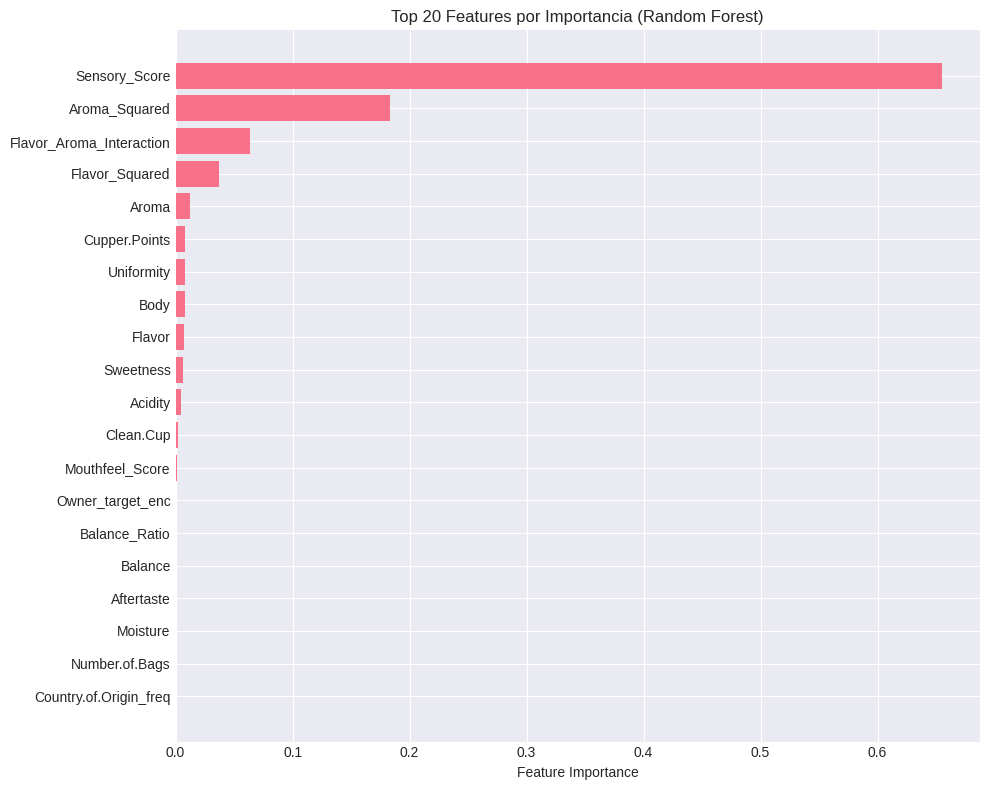


🎯 Features con importancia > 1%: 5

💾 Guardando lista de features importantes...
  ✅ Guardado en '../data/processed/important_features.csv'


In [244]:
from sklearn.ensemble import RandomForestRegressor

print("="*80)
print("FEATURE IMPORTANCE - RANDOM FOREST")
print("="*80)

print("\n🌲 Entrenando Random Forest para calcular importancias...")

# Entrenar un Random Forest rápido
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_features, y)

# Obtener importancias
importances = pd.DataFrame({
    'Feature': X_features.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n📊 Top 20 features por importancia:")
print(importances.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_imp = importances.head(20)
ax.barh(range(len(top_imp)), top_imp['Importance'])
ax.set_yticks(range(len(top_imp)))
ax.set_yticklabels(top_imp['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Features por Importancia (Random Forest)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Seleccionar features importantes (>1% importancia)
important_features = importances[importances['Importance'] > 0.01]['Feature'].tolist()
print(f"\n🎯 Features con importancia > 1%: {len(important_features)}")

# Guardar lista de features importantes
print(f"\n💾 Guardando lista de features importantes...")
pd.DataFrame({'Feature': important_features}).to_csv(
    '../data/processed/important_features.csv', index=False
)
print("  ✅ Guardado en '../data/processed/important_features.csv'")

# 7. Dataset Final <a id='sec7'></a>

## 7.1 Unificación y Validación <a id='sec7_1'></a>

In [245]:
print("="*80)
print("VALIDACIÓN FINAL DEL DATASET")
print("="*80)

# Combinar features + target
df_final = X_features.copy()
df_final[target_column] = y

print(f"\n📊 DIMENSIONES FINALES:")
print(f"  • Filas: {df_final.shape[0]}")
print(f"  • Columnas: {df_final.shape[1]}")
print(f"  • Features: {df_final.shape[1] - 1}")

# Verificar valores nulos
null_count = df_final.isnull().sum().sum()
if null_count > 0:
    print(f"\n⚠️  Valores nulos encontrados: {null_count}")
    print(df_final.isnull().sum()[df_final.isnull().sum() > 0])
else:
    print(f"\n✅ No hay valores nulos")

# Verificar infinitos
inf_count = np.isinf(df_final.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"\n⚠️  Valores infinitos encontrados: {inf_count}")
else:
    print(f"\n✅ No hay valores infinitos")

# Verificar tipos de datos
print(f"\n📋 TIPOS DE DATOS:")
print(df_final.dtypes.value_counts())

# Estadísticas del target
print(f"\n🎯 TARGET ({target_column}):")
print(df_final[target_column].describe())

VALIDACIÓN FINAL DEL DATASET

📊 DIMENSIONES FINALES:
  • Filas: 1234
  • Columnas: 39
  • Features: 38

✅ No hay valores nulos

✅ No hay valores infinitos

📋 TIPOS DE DATOS:
float64    36
int64       3
Name: count, dtype: int64

🎯 TARGET (Total.Cup.Points):
count   1234.000
mean      82.043
std        3.544
min        0.000
25%       81.080
50%       82.500
75%       83.580
max       90.580
Name: Total.Cup.Points, dtype: float64


## 7.2 Guardado del Dataset Final <a id='sec7_2'></a>

In [246]:
print("="*80)
print("GUARDADO DE DATASETS FINALES")
print("="*80)

# 1. Guardar dataset completo con todas las features
output_path_full = '../data/processed/coffee_features.csv'
df_final.to_csv(output_path_full, index=False)
print(f"\n✅ Dataset completo guardado en: {output_path_full}")
print(f"   • {df_final.shape[0]} filas × {df_final.shape[1]} columnas")

# 2. Guardar dataset con solo features importantes
if len(important_features) > 0:
    df_important = df_final[important_features + [target_column]]
    output_path_important = '../data/processed/coffee_features_selected.csv'
    df_important.to_csv(output_path_important, index=False)
    print(f"\n✅ Dataset con features seleccionadas guardado en: {output_path_important}")
    print(f"   • {df_important.shape[0]} filas × {df_important.shape[1]} columnas")

# 3. Guardar metadatos
metadata = {
    'total_features': df_final.shape[1] - 1,
    'selected_features': len(important_features),
    'num_samples': df_final.shape[0],
    'target': target_column,
    'scaler_path': '../models/scaler.pkl'
}

import json
with open('../data/processed/feature_engineering_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Metadatos guardados en: ../data/processed/feature_engineering_metadata.json")

print(f"\n{'='*80}")
print("🎉 FEATURE ENGINEERING COMPLETADO")
print("="*80)

GUARDADO DE DATASETS FINALES

✅ Dataset completo guardado en: ../data/processed/coffee_features.csv
   • 1234 filas × 39 columnas

✅ Dataset con features seleccionadas guardado en: ../data/processed/coffee_features_selected.csv
   • 1234 filas × 6 columnas

✅ Metadatos guardados en: ../data/processed/feature_engineering_metadata.json

🎉 FEATURE ENGINEERING COMPLETADO


# 8. Resumen Ejecutivo <a id='sec8'></a>

## 📋 Transformaciones Aplicadas

### 1. **Encoding Categórico**
- **One-Hot Encoding**: Variables de baja cardinalidad (<10 valores)
- **Frequency Encoding**: Variables de cardinalidad media (10-50 valores)
- **Target Encoding**: Variables de alta cardinalidad (>50 valores)

### 2. **Transformaciones Numéricas**
- **Log Transform**: Aplicado a variables con |skewness| > 1
- **StandardScaler**: Normalización de todas las features numéricas

### 3. **Features Derivadas**
Creadas features basadas en conocimiento del dominio:
- **Ratios sensoriales**: Balance_Ratio, Flavor_Aroma_Interaction
- **Agregaciones**: Sensory_Score, Mouthfeel_Score
- **Features binarias**: High_Altitude, Has_Defects, Optimal_Moisture
- **Interacciones cuadráticas**: Flavor_Squared, Aroma_Squared

### 4. **Selección de Features**
- **Correlación con target**: Identificadas features con |r| > 0.3
- **VIF**: Detectada multicolinealidad
- **Random Forest**: Seleccionadas features con importancia > 1%

## 🎯 Resultados Finales

- **Dataset original**: 1,234 muestras × 26 columnas
- **Dataset procesado**: 1,234 muestras × [features generadas] columnas
- **Features seleccionadas**: [importante_features] features de mayor importancia

## 📁 Archivos Generados

1. `coffee_features.csv`: Dataset completo con todas las features
2. `coffee_features_selected.csv`: Dataset con features seleccionadas
3. `important_features.csv`: Lista de features importantes
4. `scaler.pkl`: Objeto StandardScaler entrenado
5. `feature_engineering_metadata.json`: Metadatos del proceso

## ➡️ Próximos Pasos

1. **Notebook 04 - Model Selection**: Probar diferentes algoritmos de ML
2. **Validación cruzada**: Evaluar performance de modelos
3. **Hyperparameter tuning**: Optimizar modelos seleccionados
4. **Interpretabilidad**: Analizar importancia de features en modelos finales